# The Comparison between KNN and Linear Regression on Predicting the Danceability of a Song on Spotify
Group 79: Steve (Zefan) Liu, Zeen Lin, Erin Lau, Eric Shuai

<em>Word Count: []</em>

In [1]:
# !!! TABLE OF CONTENTS
# !!! FIGURE (LEAGUE OF) LEGEND

<h2 style="color:#008a05">Introduction</h2>

After three long years of pandemic-styled living, the desire to return to the party-scene has sparked excitement in communities worldwide (Tesfaye, 2021). To prepare for this upcoming age of buzz and festivities, it is essential for venues, DJ’s, and rising artists to consider the features of their music that increase the likelihood of dancing and fun. However, many predictors can play a role in deciding how danceable a song is. Thus, through this project, our group aims to predict the danceability of an unknown song given two sets of multiple characteristics: one set based off predictors that we believe—having learnt music theory—play a role towards danceability (using KNN regression), and another set based off a systematic process using all-subsets greedy selection (using linear regression). The accuracy of the two models will be compared based on their performance on the testing data to see how well our intuition compares to a systematic choice of selectors.

**Question:** With different sets of predictors, which of the KNN regression and the linear regression will have a better predictive performance on the danceability, and why it is the case?

For this analysis, we used the **[Spotify Audio Features dataset](https://www.kaggle.com/datasets/tomigelo/spotify-audio-features)** (<https://www.kaggle.com/datasets/tomigelo/spotify-audio-features>) captured from April 2019 by the user *tomigelo*. This dataset was scraped via Spotify API and Python and consists of various audio features (e.g. acousticness, song length, key, etc.) provided by [Spotify](https://developer.spotify.com/documentation/web-api/reference/#/operations/get-audio-features) pertaining to a given song.

<h2 style="color:#008a05">Method</h2>

We compared two models of danceability: one utilising rectangular K-Nearest Neighbours regression using predictors that we believe are related to a song’s danceability, and another created from a Linear Regression model utilising greedy selection to choose the set of predictors which has the lowest BIC value.


### K-NN Regression Model, the <span style="color:#e61a17">"Intuitive Model"</span>

##### <u><div style="text-align: center">Table 1.1: Predictor Descriptions</div></u>
| Predicted Variable                 | Name in Dataset | Type of data                |
|------------------------------------|-----------------|-----------------------------|
| **Danceability**                   | `danceability`  | (dbl, 0.0-1.0, no units)    |

| Predictor                          | Name in Dataset | Type of data                |
|------------------------------------|-----------------|-----------------------------|
| **Energy**                         | `energy`        | (dbl, 0.0-1.0, no units)    |
| **Tempo**                          | `tempo`         | (dbl, >= 0, BPM)            |
| **Valence** (musical positiveness) | `valence`       | (dbl, 0.0-1.0, no units)    |

For our first, <span style="color:#e61a17">"intuitive"</span> model, we performed **KNN regression analysis** based on three selectors: the energy, valence, and tempo of a song as predictor variables. Energy and tempo are crucial as they form the rhythmic backbones of a song’s danceability (which per [Spotify's definition](https://developer.spotify.com/documentation/web-api/reference/#/operations/get-several-audio-features:~:text=Danceability%20describes%20how%20suitable%20a%20track%20is%20for%20dancing%20based%20on%20a%20combination%20of%20musical%20elements%20including%20tempo%2C%20rhythm%20stability%2C%20beat%20strength%2C%20and%20overall%20regularity.) is based on "elements including tempo, rhythm stability, beat strength, and overall regularity"), and the valence was selected as a song expressing higher positiveness could influence the listener to dance along.

### Linear Regression Model + Greedy Selection (all subsets), the <span style="color:#00bfff">"Systematic Model"</span>
##### <u><div style="text-align: center">Table 1.2: Predicted Variable Description</div></u>
| Predicted Variable                 | Name in Dataset | Type of data                |
|------------------------------------|-----------------|-----------------------------|
| **Danceability**                   | `danceability`  | (dbl, 0.0-1.0, no units)    |

Our second, <span style="color:#00bfff">"systematic"</span> model has predictors selected from the training data set using the **greedy selection (all subsets)** technique, which iterates through all possible subsets of predictors until an optimal group of predictors have been selected.

After completing initial cleanup (trimming N/A values, selecting, etc.), we first sampled our large dataset proportionally, before creating the training/testing split. Next, we built our <span style="color:#e61a17">Intuitive Model</span>, utilising cross-validation to determine an optimal number of neighbours, $k$, which was used to retrain the model. We then created our <span style="color:#00bfff">Systematic Model</span> by performing greedy selection and using the resulting predictors. Finally, we compared the performance of our two models against our testing set through the RMSPE values to see how well our <span style="color:#e61a17">Intuitive Model</span> compared to a systematically-designed model.

<h2 style="color:#008a05">Setting up our data</h2>

### Importing Libraries and Loading Data

Begin by setting up all the primary required libraries: `repr`, `tidyverse`, and `tidymodels`. We also load `GGally` to use `ggpairs()` for data exploration, `gridExtra` to arrange plots, and install the `leaps` library to perform greedy selection.

In [2]:
# ========== Setting up prerequisites libraries ==========
library(repr)
library(tidyverse)
library(tidymodels)
library(GGally)
library(gridExtra)

# Install the leaps package and load it
install.packages("leaps")
library(leaps)

options(repr.matrix.max.rows = 8)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

Let's load our data, which was downloaded from [Kaggle](https://www.kaggle.com/datasets/tomigelo/spotify-audio-features) and hosted on our [project repository](https://github.com/eshuaiii/dsci-100-2022w1-group-79).

In [3]:
# ========== Load the data from the web into R ==========
dataset_url <- "https://github.com/eshuaiii/dsci-100-2022w1-group-79/raw/main/data/SpotifyAudioFeaturesApril2019.csv"

# read the dataset from URL
spotify_big <- read_csv(url(dataset_url))

# read the first 5 rows
head(spotify_big, 5)

Rows: 130663 Columns: 17
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (3): artist_name, track_id, track_name
dbl (14): acousticness, danceability, duration_ms, energy, instrumentalness,...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


artist_name,track_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,popularity
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
YG,2RM4jf1Xa9zPgMGRDiht8O,"Big Bank feat. 2 Chainz, Big Sean, Nicki Minaj",5.82e-03,0.743,238373,0.339,0.000,1,0.0812,-7.678,1,0.4090,203.927,4,0.118,15
YG,1tHDG53xJNGsItRA3vfVgs,BAND DRUM (feat. A$AP Rocky),2.44e-02,0.846,214800,0.557,0.000,8,0.2860,-7.259,1,0.4570,159.009,4,0.371,0
R3HAB,6Wosx2euFPMT14UXiWudMy,Radio Silence,2.50e-02,0.603,138913,0.723,0.000,9,0.0824,-5.890,0,0.0454,114.966,4,0.382,56
Chris Cooq,3J2Jpw61sO7l6Hc7qdYV91,Lactose,2.94e-02,0.800,125381,0.579,0.912,5,0.0994,-12.118,0,0.0701,123.003,4,0.641,0
Chris Cooq,2jbYvQCyPgX3CdmAzeVeuS,Same - Original mix,3.52e-05,0.783,124016,0.792,0.878,7,0.0332,-10.277,1,0.0661,120.047,4,0.928,0


### Sampling and Creating Tidy Data

Before we sample our data, we first realize that the `tempo` value currently consists of all numbers from 0 inclusive onwards. This means that some songs in our dataset would have a tempo of 0, which we questioned whether a real piece of music could have zero tempo. Through some exploratory analysis, we discovered that the observations that possessed zero tempo were recordings of white noise or podcast-like tracks, rather than actual music. As these recordings did not align with the goal of our project (that being to support DJ’s and music artists involved in the party scene), we removed all points whose `tempo` = 0 from our analysis.

In [4]:
# ========== Filter for all values whose tempo is not equals to 0 ==========
spotify_big_filtered <- spotify_big |>
    filter(tempo != 0)

We also clean up our data and remove all `NA` values.

In [5]:
# ========== Remove NA values (if they exist) ==========
spotify_big_filtered_NA_indicator <- spotify_big_filtered |> complete.cases()
spotify_big_cleaned <- spotify_big_filtered[spotify_big_filtered_NA_indicator,]

# Taking a look at whether NA values were removed 
spotify_big_cleaned

artist_name,track_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,popularity
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
YG,2RM4jf1Xa9zPgMGRDiht8O,"Big Bank feat. 2 Chainz, Big Sean, Nicki Minaj",0.00582,0.743,238373,0.339,0.000,1,0.0812,-7.678,1,0.4090,203.927,4,0.118,15
YG,1tHDG53xJNGsItRA3vfVgs,BAND DRUM (feat. A$AP Rocky),0.02440,0.846,214800,0.557,0.000,8,0.2860,-7.259,1,0.4570,159.009,4,0.371,0
R3HAB,6Wosx2euFPMT14UXiWudMy,Radio Silence,0.02500,0.603,138913,0.723,0.000,9,0.0824,-5.890,0,0.0454,114.966,4,0.382,56
Chris Cooq,3J2Jpw61sO7l6Hc7qdYV91,Lactose,0.02940,0.800,125381,0.579,0.912,5,0.0994,-12.118,0,0.0701,123.003,4,0.641,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Saint Claire,43MP9F7UzvfilSrw2SqZGJ,Enough for You,0.9180,0.387,194583,0.249,0,9,0.1030,-13.233,1,0.0437,94.039,4,0.3460,60
Mike Stud,4TWlUuFk81NGUNKwndyS5Q,Do It,0.3300,0.717,139191,0.532,0,8,0.0997,-8.351,0,0.2060,156.977,4,0.5460,47
D Savage,5iGBXzOoRo4sBTy8wdzMyK,No Smoke,0.0079,0.772,180013,0.510,0,4,0.1310,-9.670,0,0.1200,120.049,4,0.0755,50
Banda Los Sebastianes,7LNtyuekYHiZ99UxkrfCQR,En Vida,0.5490,0.715,145827,0.734,0,3,0.1080,-3.244,1,0.0367,130.128,3,0.9760,55


We set our seed to our group number (79) and sample 2079 data points from our dataset using the sample_n() function to ensure an equal split (2079 was selected simply because it has the number 79 in it). Lastly, per the [Spotify API docs](https://developer.spotify.com/documentation/web-api/reference/#/operations/get-several-audio-features), we change `key`, `mode`, and `time_signature` to categorical variables using the mutate() function, and remove `popularity` as it is not a musical feature of a song.

In [6]:
# ========== Setting our seed once ==========
set.seed(79)

# ========== Extract 2079 values using the 
raw_spotify <- spotify_big_filtered |>
    sample_n(2079) |>
    # select all numeric values
    select(acousticness, danceability, duration_ms, energy, instrumentalness, key, liveness, loudness, mode, speechiness, tempo, time_signature, valence) |>
    mutate(key = as.factor(key),
           mode = as.factor(mode),
           time_signature = as.factor(time_signature))
raw_spotify

acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<fct>,<dbl>
0.897,0.212,150857,0.254,8.37e-01,9,0.1110,-20.003,0,0.0487,140.897,4,0.0398
0.161,0.727,189465,0.704,2.31e-06,7,0.0987,-6.295,0,0.2210,133.913,4,0.3430
0.991,0.451,94000,0.143,9.27e-01,8,0.1070,-25.762,1,0.0740,114.721,4,0.1820
0.840,0.487,240937,0.203,1.80e-02,4,0.1700,-14.686,1,0.0395,127.880,3,0.5050
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
0.1010,0.507,116477,0.804,1.33e-02,1,0.203,-4.986,0,0.2030,152.039,4,0.633
0.0195,0.884,185137,0.590,0.00e+00,8,0.108,-4.886,1,0.3770,74.947,4,0.346
0.3470,0.777,213333,0.500,4.16e-06,1,0.111,-7.000,1,0.0644,135.020,4,0.145
0.0034,0.734,72447,0.922,9.22e-05,7,0.123,-2.401,1,0.1060,100.006,4,0.790


Let's create our training and testing splits, using (once again) 79% for training and 21% for testing, and `danceability` as our strata argument.

In [7]:
spotify_split <- initial_split(raw_spotify, prop = 0.79, strata = danceability)
spotify_training <- training(spotify_split)
spotify_testing <- testing(spotify_split)

spotify_training

acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<fct>,<dbl>
8.97e-01,0.212,150857,0.254,0.8370,9,0.111,-20.003,0,0.0487,140.897,4,0.0398
9.91e-01,0.451,94000,0.143,0.9270,8,0.107,-25.762,1,0.0740,114.721,4,0.1820
1.82e-05,0.449,167226,0.973,0.0581,4,0.374,-3.786,1,0.0837,155.023,4,0.7190
9.15e-01,0.409,182107,0.253,0.0278,3,0.104,-9.880,0,0.0363,114.023,3,0.2180
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
0.0198,0.788,139050,0.509,2.14e-02,6,0.0976,-8.763,1,0.1630,154.960,4,0.887
0.0195,0.884,185137,0.590,0.00e+00,8,0.1080,-4.886,1,0.3770,74.947,4,0.346
0.3470,0.777,213333,0.500,4.16e-06,1,0.1110,-7.000,1,0.0644,135.020,4,0.145
0.0034,0.734,72447,0.922,9.22e-05,7,0.1230,-2.401,1,0.1060,100.006,4,0.790


<h2 style="color:#008a05">Preliminary Exploratory Data Analysis</h2>

### <span style="color:#e61a17">Intuitive Model</span>

First, let's select the variables based on our intuition and explore the statistical summary of the variables. We store this new dataframe as `spotify_training_intuitive_unscaled`.

In [8]:
# ========== Dataframe with our intuitive data ==========
# select all the predictors we're interested in (energy, tempo, valence)

spotify_training_intuitive_unscaled <- spotify_training |>
    select(danceability, energy, tempo, valence) |>
    mutate(energy = as.numeric(energy),
           tempo = as.numeric(tempo),
           valence = as.numeric(valence))
head(spotify_training_intuitive_unscaled, 5)

danceability,energy,tempo,valence
<dbl>,<dbl>,<dbl>,<dbl>
0.212,0.254,140.897,0.0398
0.451,0.143,114.721,0.1820
0.449,0.973,155.023,0.7190
0.409,0.253,114.023,0.2180
0.417,0.733,141.536,0.7250


In [9]:
# # ========== A statistical summary of our Intuitive Model predictors ==========
spotify_training_intuitive_summary <- spotify_training_intuitive_unscaled |>
                            summarize(number_of_observations = n(),
                                      mean_danceability = mean(danceability),
                                      mean_energy = mean(energy),
                                      mean_tempo = mean(tempo),
                                      mean_valence = mean(valence),
                                      sd_danceability = sd(danceability),
                                      sd_energy = sd(energy),
                                      sd_tempo = sd(tempo),
                                      sd_valence = sd(valence))
spotify_training_intuitive_summary

number_of_observations,mean_danceability,mean_energy,mean_tempo,mean_valence,sd_danceability,sd_energy,sd_tempo,sd_valence
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1639,0.5846792,0.5659,118.346,0.4284079,0.1868775,0.2616224,28.50608,0.2604727


We can see that the data has a danceability mean of roughly 0.583, an average energy of 0.567, and an average valence of 0.431. This is a good indicator of well-split data, as the mean revolves in the middle of the two extremes (0 and 1). The average song BPM is approximately 120 BPM.

Next, let's plot each variable against `danceability`.

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'



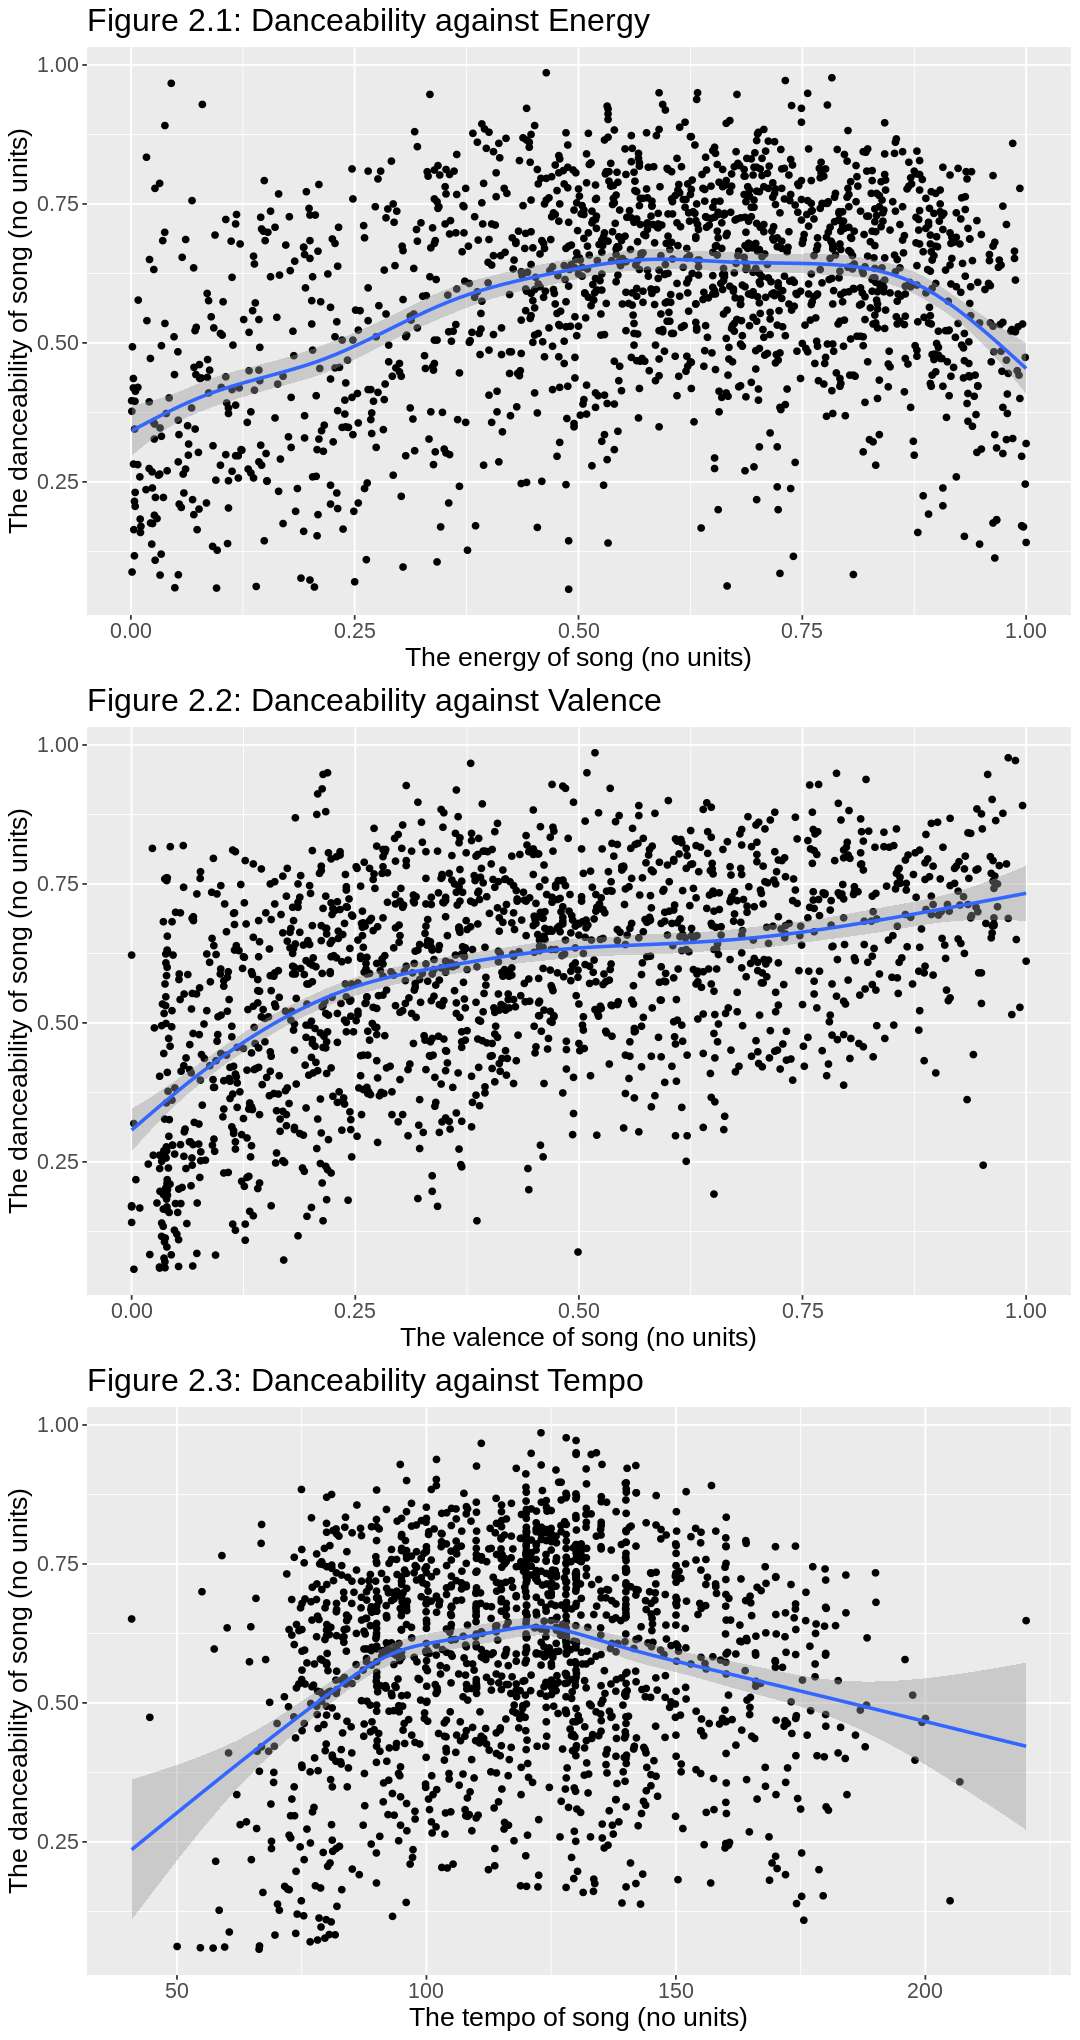

In [10]:
# ========== General Visualizations for Intuitive Model predictors ==========
options(repr.plot.width = 9, repr.plot.height = 17)
# Visualize the relationship between danceability and energy, classified by mode
intuitive_energy_plot <- ggplot(spotify_training_intuitive_unscaled, aes(x = energy, y = danceability)) +
    geom_point(alpha = 1.1) +
    geom_smooth() +
    labs(x = "The energy of song (no units)", y = "The danceability of song (no units)") +
    theme(text = element_text(size = 16)) +
    ggtitle("Figure 2.1: Danceability against Energy")

# Visualize the relationship between danceability and valence, classified by mode
intuitive_valence_plot <- ggplot(spotify_training_intuitive_unscaled, aes(x = valence, y = danceability)) +
    geom_point(alpha = 1.1) +
    geom_smooth() +
    labs(x = "The valence of song (no units)", y = "The danceability of song (no units)") +
    theme(text = element_text(size = 16)) +
    ggtitle("Figure 2.2: Danceability against Valence")

# Visualize the relationship between danceability and tempo, classified by mode
intuitive_tempo_plot <- ggplot(spotify_training_intuitive_unscaled, aes(x = tempo, y = danceability)) +
    geom_point(alpha = 1.1) +
    geom_smooth() +
    labs(x = "The tempo of song (no units)", y = "The danceability of song (no units)") +
    theme(text = element_text(size = 16)) +
    ggtitle("Figure 2.3: Danceability against Tempo")

grid.arrange(intuitive_energy_plot, intuitive_valence_plot, intuitive_tempo_plot)

Although these visualizations show some overplotting due to a large set of data, the general trend outlined by the `geom_smooth()` line is noticeable for the energy and valence of a song. For tempo, the trend is discernible, but not quite as obvious.

### <span style="color:#00bfff">Systematic Model</span>

The first stage of filtering the data needed for the linear regression model is to select all possible continuous and categorical variables that will be most effective for the model.
<br>However, since we might conduct cross-validation for comparison with others in the future, adding categorical variables with many levels will greatly affect the model’s performance. Hence, we first remove `key` and `time_signature` from our analysis.

In [11]:
# ========== Removing large categorical variables ==========
spotify_training_systematic_filter_stage_1 <- spotify_training |>
                                               select(-key, -time_signature)
head(spotify_training_systematic_filter_stage_1, 5)

acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,mode,speechiness,tempo,valence
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>
8.97e-01,0.212,150857,0.254,0.8370,0.111,-20.003,0,0.0487,140.897,0.0398
9.91e-01,0.451,94000,0.143,0.9270,0.107,-25.762,1,0.0740,114.721,0.1820
1.82e-05,0.449,167226,0.973,0.0581,0.374,-3.786,1,0.0837,155.023,0.7190
9.15e-01,0.409,182107,0.253,0.0278,0.104,-9.880,0,0.0363,114.023,0.2180
4.54e-02,0.417,39070,0.733,0.0000,0.710,-10.404,1,0.2940,141.536,0.7250


Next, we use `ggpairs()` and the correlation matrix to check the strength of each variable’s relationship with danceability. For plotting simplicity, we ignore `mode` (the only categorical variable remaining) for now.

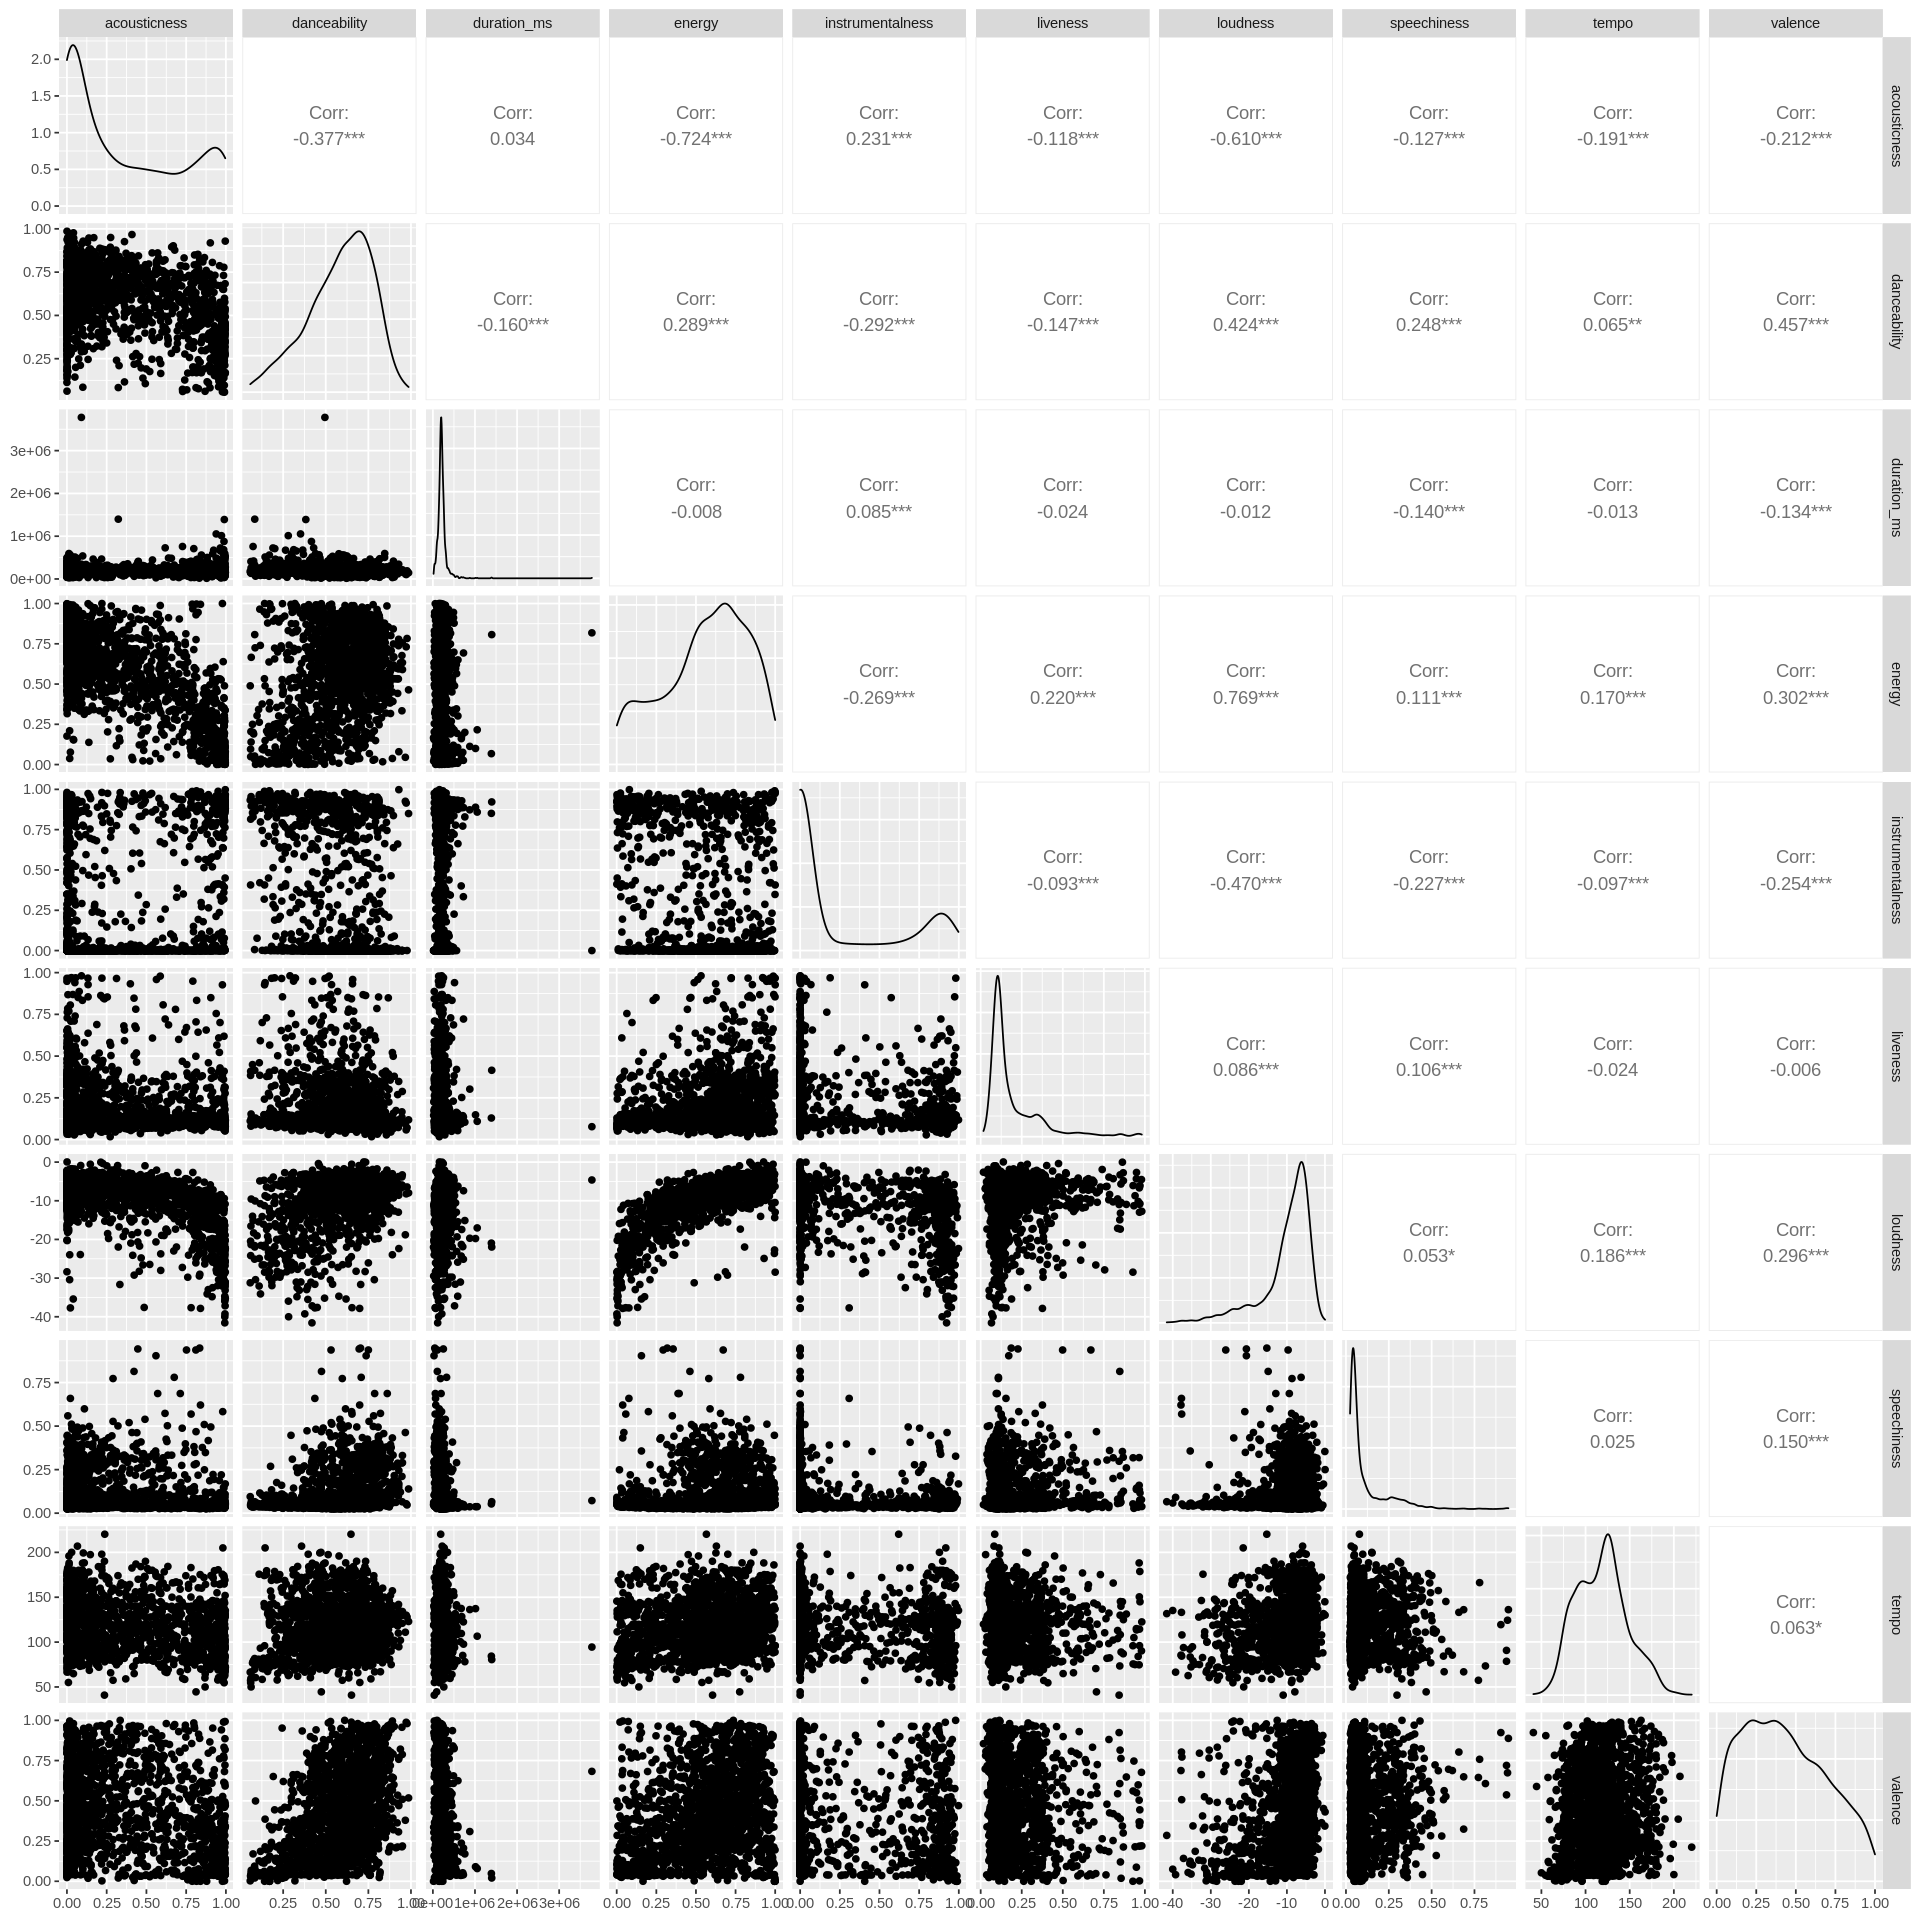

In [12]:
# ========== Create a ggpairs plot with all continuous variables ==========
options(repr.plot.width = 16, repr.plot.height = 16)
spotify_training_systematic_continuous <- spotify_training_systematic_filter_stage_1 |> select(-mode)
systematic_relationship_check_graph <- ggpairs(spotify_training_systematic_continuous)
systematic_relationship_check_matrix <- cor(spotify_training_systematic_continuous)

systematic_relationship_check_graph

In [13]:
# ========== Show the correlation matrix ==========
systematic_relationship_check_matrix

# show only variables against danceability
systematic_relationship_check_matrix[2,]

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
acousticness,1.00000000,-0.3774612,0.033726042,-0.723957382,0.23086151,-0.11792656,-0.61019366,-0.1265897,-0.19129753,-0.2116819
danceability,-0.37746119,1.0000000,-0.159876642,0.288602272,-0.29158477,-0.14716910,0.42355995,0.2480486,0.06524669,0.4570291
duration_ms,0.03372604,-0.1598766,1.000000000,-0.008144273,0.08486741,-0.02406055,-0.01159307,-0.1401172,-0.01335215,-0.1340225
energy,-0.72395738,0.2886023,-0.008144273,1.000000000,-0.26900055,0.21964044,0.76905734,0.1109639,0.16957394,0.3017204
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
loudness,-0.6101937,0.42355995,-0.01159307,0.7690573,-0.4700360,0.086471106,1.00000000,0.05281911,0.18598232,0.29557798
speechiness,-0.1265897,0.24804855,-0.14011720,0.1109639,-0.2274675,0.105532343,0.05281911,1.00000000,0.02464738,0.15013398
tempo,-0.1912975,0.06524669,-0.01335215,0.1695739,-0.0974252,-0.024372007,0.18598232,0.02464738,1.00000000,0.06272626
valence,-0.2116819,0.45702908,-0.13402255,0.3017204,-0.2537023,-0.006393251,0.29557798,0.15013398,0.06272626,1.00000000


acousticness     danceability      duration_ms           energy 
     -0.37746119       1.00000000      -0.15987664       0.28860227 
instrumentalness         liveness         loudness      speechiness 
     -0.29158477      -0.14716910       0.42355995       0.24804855 
           tempo          valence 
      0.06524669       0.45702908

From the plot and matrix, the variables with relatively strong correlations with danceability include `valence`, `loudness`, `acousticness`, `instrumentalness`, and `energy`. We also select `mode` as one of the potential variables that can predict danceability.

In [14]:
spotify_training_systematic <- spotify_training_systematic_filter_stage_1 |>
                                    select(danceability, valence, loudness, acousticness,
                                           instrumentalness, energy, mode)

spotify_training_systematic

danceability,valence,loudness,acousticness,instrumentalness,energy,mode
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.212,0.0398,-20.003,8.97e-01,0.8370,0.254,0
0.451,0.1820,-25.762,9.91e-01,0.9270,0.143,1
0.449,0.7190,-3.786,1.82e-05,0.0581,0.973,1
0.409,0.2180,-9.880,9.15e-01,0.0278,0.253,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮
0.788,0.887,-8.763,0.0198,2.14e-02,0.509,1
0.884,0.346,-4.886,0.0195,0.00e+00,0.590,1
0.777,0.145,-7.000,0.3470,4.16e-06,0.500,1
0.734,0.790,-2.401,0.0034,9.22e-05,0.922,1


<h2 style="color:#008a05">Data Analysis</h2>

### <span style="color:#e61a17">Intuitive Model</span>

We begin by creating our spec with the `nearest_neighbor()` function, ensuring to `tune()` our neighbors. We also create our recipe with all three predictors (`energy`, `valence`, `tempo`) against `danceability`, ensuring to scale and centre our data.

In [15]:
# ========== Creating our spec, spotify_spec, and tuning neighbours ==========
spotify_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
      set_engine("kknn") |>
      set_mode("regression")

# ========== Creating our recipe, spotify_recipe, with energy, valence, and tempo against danceability ==========
spotify_recipe <- recipe(danceability ~ ., data = spotify_training_intuitive_unscaled) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

Next, we set up our cross-validation object with 5 folds and create our `workflow`, which we pass both into `tune_grid()` to determine the optimal number for $k$, testing neighbours from 1-500.

In [ ]:
# ========== Perform cross-validation ==========
spotify_vfold <- vfold_cv(spotify_training_intuitive_unscaled, v = 5, strata = danceability)
spotify_workflow <- workflow() |>
    add_recipe(spotify_recipe) |>
    add_model(spotify_spec)
spotify_workflow

# ========== Test 1-200 neighbours and collect results, storing into spotify_results ==========
gridvals <- tibble(neighbors = seq(1, 500))
spotify_results <- spotify_workflow |>
    tune_grid(resamples = spotify_vfold, grid = gridvals) |>
    collect_metrics()
spotify_results

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


Now, we filter for our $k$ value with the smallest RMSPE value. We then repeat the training process into `spotify_best_fit`, using this $k$ value as our neighbours.

In [ ]:
# ========== Filter for smallest RMSPE value and store k into k_min ==========
spotify_min <- spotify_results |>
    filter(.metric == "rmse") |>
    arrange(mean) |>
    slice(1)
spotify_min 

# ========== Find our smallest k value, k_min ==========
k_min <- spotify_min |> 
    pull(neighbors)

# ========== Retrain everything, using k_min neighbours and the same recipe as above ==========
spotify_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) |>
    set_engine("kknn") |>
    set_mode("regression")

spotify_best_fit <- workflow() |>
    add_recipe(spotify_recipe) |>
    add_model(spotify_best_spec) |>
    fit(data = spotify_training_intuitive_unscaled)

We can see here that `tune()` picked $k = 51$ as the ideal number of neighbours. This has an RMSPE value of around $0.148$ with a standard error of around $0.003$.

Now we test our model against our testing data! First, we keep only needed columns in our testing data (`danceability`, `energy`, `valence`, `tempo`), and then use `predict()` with our workflow against our testing data.

In [ ]:
# ========== Select all required columns from our testing data ==========
spotify_testing_cleaned <- spotify_testing |>
    select(danceability, energy, valence, tempo)

# ========== And predict! ==========
spotify_summary <- spotify_best_fit |>
    predict(spotify_testing_cleaned) |>
    bind_cols(spotify_testing_cleaned) |>
    metrics(truth = danceability, estimate = .pred)
spotify_summary

Our final RMSPE value for our testing set is around $0.142$. This means that whatever our model predicts a song's danceability (range: 0-1) to be, it can fluctuate by 0.142 up or down from the actual value. [STANDARD ERROR]

We finally plot each predictor against the `danceability` value by using the model with our training data, with our model displayed as a blue line.

In [ ]:
# ========== Predict our training data ==========
spotify_preds <- spotify_best_fit |>
    predict(spotify_training) |>
    bind_cols(spotify_training)

# ========== Plotting our data ==========
options(repr.plot.width = 11, repr.plot.height = 20)
spotify_plot_energy <- ggplot(spotify_preds, aes(x = energy, y = danceability)) +
    geom_point() +
    geom_line(mapping = aes(x = energy, y = .pred), color = "blue") +
    labs(x = "Energy of song (no units)", y = "Dancebility of song (no units)", color = "Predicted Danceability") +
    theme(text = element_text(size = 16)) +
    ggtitle("Figure 3.1: Danceability against Energy of Song with Predictions")

spotify_plot_valence <- ggplot(spotify_preds, aes(x = valence, y = danceability)) +
    geom_point() +
    geom_line(mapping = aes(x = valence, y = .pred), color = "blue") +
    labs(x = "Valence of song (no units)", y = "Dancebility of song (no units)", color = "Predicted Danceability") +
    theme(text = element_text(size = 16)) +
    ggtitle("Figure 3.2: Danceability against Valence of Song with Predictions")

spotify_plot_tempo <- ggplot(spotify_preds, aes(x = tempo, y = danceability)) +
    geom_point() +
    geom_line(mapping = aes(x = tempo, y = .pred), color = "blue") +
    labs(x = "Tempo of song (BPM)", y = "Dancebility of song (no units)", color = "Predicted Danceability") +
    theme(text = element_text(size = 16)) +
    ggtitle("Figure 3.3: Danceability against Tempo of Song with Predictions")

grid.arrange(spotify_plot_energy, spotify_plot_valence, spotify_plot_tempo)

### <span style="color:#00bfff">Systematic Model</span>

We begin our systematic analysis using linear regression and greedy selection on all subsets.

Specifically, considering that there is no single variable that has a correlation coefficient larger than 0.5 with `danceability`, it is quite arbitrary and invalid to use the full model or a random subset of the predictors directly. <br>
Thus, we will not be using forward selection as the dimension is not too high, and will conduct greedy selection to find the best subset of variables.

We do not need to centre and scale the data as it will not affect the performance of linear regression.

In [ ]:
# ========== Running subsets ==========
full_model <- regsubsets(danceability ~ ., data = spotify_training_systematic)
# show the best models under each dimension
summary(full_model)

Now, we pick the best model under all dimensions using BIC/Mallow's Cp value.

Like cross-validation, BIC and Mallow's Cp value are also criterions that estimate the prediction error. We will be using BIC across all potential best models to pick the final best one.

In [ ]:
# ========== Create a tibble with the number of predictors and the BIC value ==========
BIC_tibble <- tibble(number_of_predictors = 1:6,
                     BIC_value = summary(full_model)$bic)

# ========== Plot the BIC value against dimension ==========
options(repr.plot.width = 8, repr.plot.height = 5)
BIC_plot <- ggplot(data = BIC_tibble,
                   aes(x = number_of_predictors,
                       y = BIC_value))+ 
            geom_point() +
            geom_line() +
            labs(x = "number of predictors", y = "BIC value") +
            theme(text = element_text(size = 16)) +
            ggtitle("Figure 4.1: BIC value against number of predictors")
BIC_plot

From this plot, we can see that the ideal BIC should be 5. Hence, from our greedy selection summary above, we should pick all predictors but instrumentalness.

In [ ]:
# ========== Selecting optimal predictors ==========
spotify_systematic_training_optimal <- spotify_training_systematic |> select(-instrumentalness, -mode)
optimal_model <- lm(danceability ~ ., data = spotify_systematic_training_optimal)

We now check the residual plot and ggplot, to test the special pattern of data and the normality of residuals.

In [ ]:
# ========== Check residual plot and qqplot ==========
options(repr.plot.width = 7, repr.plot.height = 7)
residual_plot <- plot(optimal_model, which = 1)
ggplot <- plot(optimal_model, which = 2)
residual_plot
ggplot

Since there is no apparent pattern of residuals and the qqplot is approximately a straight line, the validity of the model is approximately proven.

Finally, calculate the RMSPE value of our Systematic Model against testing data.

In [ ]:
# check the performance of the model on the test set
prediction_test <- predict(optimal_model, newdata = spotify_testing) |> as_tibble()
colnames(prediction_test) <- c("prediction")
# then append the prediction result to the original testing set
spotify_testing_complete <- cbind(spotify_testing, prediction_test)
# compute the RMSPE on the testing set
RMSPE_regression <- with(spotify_testing_complete, sqrt(mean((prediction-danceability)^2)))
RMSPE_regression

The Systematic Model produced an RMSPE of 0.148 on testing data.

<h2 style="color:#008a05">Results and Discussion</h2>

For our analysis, we created two different models to assess our data: an “Intuitive Model” and a “Systematic Model”. The Intuitive Model uses multivariable K-NN regression analysis with cross-validation and neighbour tuning with three predictors (energy, valence, tempo) based on what we believed were important elements of a song’s danceability. The Systematic Model used linear regression with the best subset of predictors (valence, loudness, acousticness, energy, mode) based on the minimum BIC values. Both models produced similar RMSPE values—0.142 for the Intuitive Model (0.003 standard error) and 0.148 for the Systematic Model.

Although different methods were used to select these predictors, a common predictor, “energy”, appeared to be influential for both models. This may simply be a coincidence, but Howlin & Rooney (2021) report that in pain management contexts, participants are inclined to choose high-energy songs that are appropriate for dancing. This implies that `energy` may have enhanced our models' prediction accuracy and reduced RMSPE. by taking energy into account in this analysis.

### Limitations

For our Intuition Model, the main issue is the scientific validity of using our intuition to pick selectors at the beginning of the feature-filtering process. Our “knowledge” of music may help the prediction to some extent, but is not consistent between people and cannot be proven concretely using the data, possibly rendering the analysis invalid. Following a more systematic (but more complex) selection procedure, such as through forward selection or similar, can be investigated in the future to better fine-tune the model.

For the Systematic Model, BIC, Cp, and RMSE by cross-validation are basically estimating the same thing, which is the prediction error of a model. Due to the small deviation in the calculation of the three, using Cp or RMSE by CV to select the model could potentially produce another “optimal subset," which is valid but slightly different from our current one. This means that the predictors we currently have may not be the only set that can predict well. We can also improve our Systematic Model by introducing feature mapping or generation procedure and by adding more quadratic or interaction terms.

Though the results of the models were very similar, we believe that our systematic model was more accurate as it utilized a calculated subset of predictors as opposed to predictors chosen solely based on our intuition. If the relationship is non-linear, the K-NN Intuitive Model would work best to predict danceability. However, if the relationship is linear, the Linear Regression Systematic Model is much more stable, generating much fewer variances than the former model, similar to most complex nonparametric models.


### Impacts and Future Questions

These findings have the potential to transform the party scene, aiding in a musician’s ability to cater to their audience based on how upbeat and danceable they want their song to be. Through our findings, DJ’s and artists can implement music that emphasizes certain characteristics to further engage large crowds, ultimately increasing revenue and the artist’s prevalence. Alternatively, these findings could be found helpful by artists wishing to create music that is the *opposite* of danceable. Similarly, they will be able to use our findings to dictate how they would like to use instrumentalnesss, for example, in their music to compose a piece that will satisfy their target audience. 

Though we were able to determine which variables in our data set were most relevant to predicting danceability, we also realized that there are other factors that contribute to the success of a danceable song. One of these factors is the response variable itself. In the Spotify data set, the variable “danceability” is characterized by beat strength, stability, and regularity, leading us to question whether or not “danceability” is an unbiased, objective variable. Another factor that contributes to the success of a song is the culture of the community it was created for. For example, festival music created in Western countries may be extremely different compared to music made in China (Cowen et al., 2020). Due to this, our group is unsure whether or not our findings can apply to artists globally, encouraging us to question how predictors vary depending on the culture the music was intended for.

### Citations
Cowen, A. S., Fang, X., Sauter, D., & Keltner, D. (2020). What music makes us feel: At least 13 dimensions organize subjective experiences associated with music across different cultures. Proceedings of the National Academy of Sciences of the United States of America. Retrieved December 6, 2022, from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6995018/ 

Howlin, C., & Rooney, B. (2021). Patients choose music with high energy, danceability, and lyrics in analgesic music listening interventions. Psychology of Music, 49(4), 931–944. https://doi.org/10.1177/0305735620907155

Spotify. (n.d.). Get Tracks' Audio Features. Web API Reference | Spotify for Developers. Spotify. Retrieved October 29, 2022, from https://developer.spotify.com/documentation/web-api/reference/#/operations/get-several-audio-features

Tesfaye, E. (2021, April 17). Life in the roaring 2020s: Young people prepare to party, Reclaim lost pandemic year. NPR. Retrieved October 29, 2022, from https://www.npr.org/2021/04/17/987865318/life-in-the-roaring-2020s-young-people-prepare-to-party-reclaim-lost-pandemic-ye 

*Tomigelo*. (2019, April 14). Spotify audio features. Kaggle. Retrieved October 29, 2022, from https://www.kaggle.com/datasets/tomigelo/spotify-audio-features 


<br><br><br>
*Thank you! - Group 79*